In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

## 1. Walidacja i czyszczenie danych

Pierwszym krokiem w procesie przygotowania danych jest weryfikacja ich jakości
oraz identyfikacja wartości, które są trudne do interpretacji w kontekście
biznesowym.

Na podstawie przeprowadzonej analizy eksploracyjnej (EDA) zidentyfikowano, że:

- zmienna `CreditScore` zawiera braki danych,
- w zmiennych `Income` oraz `LoanAmount` występują wartości ujemne, które
  w kontekście kredytowym są nielogiczne i mogą wskazywać na błędy w danych
  lub szczególne przypadki.

Wartości ujemne w zmiennych `Income` oraz `LoanAmount` zostały potraktowane jako
błędne i zamienione na brak danych (`NaN`). Takie podejście pozwala:

- zachować wszystkie obserwacje w zbiorze danych,
- uniknąć wprowadzania arbitralnych korekt (np. „obcinania” do zera),
- spójnie obsłużyć problem na etapie pipeline’u poprzez imputację braków danych,
  bez ryzyka wycieku informacji pomiędzy zbiorem treningowym i testowym.

Dzięki temu dane wejściowe do modelu są logicznie spójne i przygotowane
do dalszych etapów przetwarzania.


In [3]:
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")


In [4]:
df = train.copy()


In [5]:
cols_with_negative = ["Income", "LoanAmount"]

for col in cols_with_negative:
    df.loc[df[col] < 0, col] = np.nan


In [6]:
(df[cols_with_negative] < 0).sum(), df.isna().sum()


(Income        0
 LoanAmount    0
 dtype: int64,
 Age                   0
 Income               11
 CreditScore        2383
 LoanAmount            2
 EmploymentYears       0
 NumDependents         0
 DebtToIncome          0
 EducationLevel        0
 FavoriteColor         0
 Hobby                 0
 Default               0
 dtype: int64)

Wartości ujemne w zmiennych `Income` oraz `LoanAmount` zostały potraktowane jako
błędne i zamienione na brak danych (`NaN`).  
Dzięki temu ich obsługa zostanie w sposób spójny uwzględniona w pipeline
przy użyciu mechanizmów imputacji, bez ryzyka wycieku informacji między
zbiorem treningowym i testowym.


## 2. Rozdzielenie typów cech i preprocessing

Na podstawie EDA cechy zostały podzielone na:

- **numeryczne** – zmienne ilościowe opisujące profil klienta i jego sytuację finansową,
- **kategoryczne** – cechy opisowe (`FavoriteColor`, `Hobby`), które wymagają kodowania.

Zmienne numeryczne będą poddane imputacji braków danych z użyciem mediany,
natomiast zmienne kategoryczne – imputacji najczęstszej wartości oraz kodowaniu
One-Hot Encoding. Cały proces przygotowania danych zostaje zamknięty w jednym
pipeline, co:

- eliminuje ryzyko wycieku informacji (data leakage),
- zapewnia spójność pomiędzy treningiem i walidacją,
- umożliwia łatwą podmianę modeli bez zmiany logiki przetwarzania danych.


In [7]:
target = "Default"

num_features = [
    "Age",
    "Income",
    "CreditScore",
    "LoanAmount",
    "EmploymentYears",
    "NumDependents",
    "DebtToIncome",
    "EducationLevel"
]

cat_features = [
    "FavoriteColor",
    "Hobby"
]


In [8]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)


## 3. Transformacje cech (opcjonalne)

Część zmiennych numerycznych, takich jak `Income` czy `LoanAmount`, charakteryzuje
się skośnymi rozkładami oraz długimi ogonami. W przypadku modeli liniowych
może to negatywnie wpływać na stabilność uczenia oraz jakość predykcji.

Modele drzewiaste (np. XGBoost) są w dużej mierze odporne na takie właściwości danych,
natomiast modele liniowe (np. regresja logistyczna) często wymagają dodatkowych
transformacji oraz skalowania cech.

W związku z tym w dalszym etapie projektu zastosowane zostaną dwa podejścia:

- model liniowy (Logistic Regression) jako prosty, interpretowalny baseline,
- model drzewiasty (XGBoost) jako bardziej elastyczny model nieliniowy.

Pozwoli to porównać:
- wpływ transformacji cech,
- zachowanie modeli o różnej naturze,
- kompromis pomiędzy interpretowalnością a jakością predykcji.


## 4. Nowe cechy (Feature Engineering)

Na podstawie EDA oraz wiedzy domenowej wprowadzono niewielką liczbę
dodatkowych cech, które wprost odzwierciedlają sytuację finansową klienta:

- `Income_per_Dependent` – dochód przypadający na osobę na utrzymaniu,
- `Loan_to_Income` – relacja kwoty kredytu do dochodu,
- `Employment_Ratio` – relacja lat zatrudnienia do wieku klienta.

Cechy te mają jednoznaczne uzasadnienie biznesowe i mogą lepiej oddawać
rzeczywisty poziom obciążenia finansowego oraz stabilności klienta
niż surowe zmienne wejściowe.

Ich liczba została celowo ograniczona, aby uniknąć zbyt skomplikowanego
modelu oraz zachować czytelność i interpretowalność rozwiązania.


Dochód na osobę na utrzymaniu:

In [9]:
df["Income_per_Dependent"] = df["Income"] / (df["NumDependents"] + 1)


Relacja kwoty kredytu do dochodu:

In [10]:
df["Loan_to_Income"] = df["LoanAmount"] / (df["Income"] + 1e-6)


Stabilność zatrudnienia względem wieku

In [11]:
df["Employment_Ratio"] = df["EmploymentYears"] / (df["Age"] + 1e-6)


Poniższe cechy zostały dodane na etapie przygotowania danych, jeszcze przed budową pipeline’u.
Są one deterministycznie wyliczane na podstawie istniejących zmiennych i nie wprowadzają ryzyka wycieku informacji.
Ich celem jest lepsze uchwycenie rzeczywistego obciążenia finansowego oraz stabilności klienta w sposób zrozumiały biznesowo.

In [12]:
# Zakładamy, że df = train.copy() i że wartości ujemne Income/LoanAmount zostały zamienione na NaN

eps = 1e-6

df["Income_per_Dependent"] = df["Income"] / (df["NumDependents"] + 1)
df["Loan_to_Income"] = df["LoanAmount"] / (df["Income"] + eps)
df["Employment_Ratio"] = df["EmploymentYears"] / (df["Age"] + eps)

# Aktualizacja listy cech numerycznych
num_features = [
    "Age", "Income", "CreditScore", "LoanAmount",
    "EmploymentYears", "NumDependents", "DebtToIncome", "EducationLevel",
    "Income_per_Dependent", "Loan_to_Income", "Employment_Ratio"
]


In [13]:
df[["Income_per_Dependent", "Loan_to_Income", "Employment_Ratio"]].describe()


,Income_per_Dependent,Loan_to_Income,Employment_Ratio
count,19989.000000,19987.000000,20000.000000
mean,22903.237859,0.486580,0.482002
std,16601.666615,3.722019,0.350193
min,11.488607,0.004701,0.000000
25%,11416.335282,0.308515,0.208333
50%,16725.304429,0.399298,0.428571
75%,28859.647147,0.528497,0.673913
max,117186.263765,521.768540,1.857143


## 5. Pipeline i modele bazowe

W celu porównania różnych podejść do problemu zastosowane zostaną dwa modele:

- regresja logistyczna – prosty, interpretowalny model liniowy,
- XGBoost – model drzewiasty, dobrze radzący sobie z nieliniowościami.

Dla każdego z modeli zbudowany zostanie osobny pipeline, obejmujący
przygotowanie danych oraz proces uczenia.



In [14]:
numeric_transformer_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lr, num_features),
        ("cat", categorical_transformer_lr, cat_features)
    ]
)

pipeline_lr = Pipeline(steps=[
    ("preprocessor", preprocessor_lr),
    ("model", LogisticRegression(max_iter=1000))
])


In [15]:
numeric_transformer_xgb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_xgb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_xgb, num_features),
        ("cat", categorical_transformer_xgb, cat_features)
    ]
)

pipeline_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor_xgb),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])


## 6. Walidacja krzyżowa i porównanie modeli

W celu uzyskania stabilnej oceny jakości modeli zastosowano walidację krzyżową
z użyciem metryki ROC-AUC, która lepiej niż accuracy odzwierciedla zdolność
modelu do separacji klientów wysokiego i niskiego ryzyka.

Porównane zostaną dwa podejścia:
- regresja logistyczna jako prosty, interpretowalny baseline,
- XGBoost jako model nieliniowy o większej elastyczności.


In [16]:
# 1) po czyszczeniu i po dodaniu nowych cech:
target = "Default"

X = df.drop(columns=[target]).copy()
y = df[target].copy()



In [17]:
expected = set(num_features + cat_features)
actual = set(X.columns)

missing = sorted(expected - actual)
extra = sorted(actual - expected)

missing, extra[:10]


([], [])

In [18]:
numeric_transformer_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lr, num_features),
        ("cat", categorical_transformer_lr, cat_features)
    ]
)

pipeline_lr = Pipeline(steps=[
    ("preprocessor", preprocessor_lr),
    ("model", LogisticRegression(max_iter=1000))
])


In [19]:
numeric_transformer_xgb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_xgb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_xgb, num_features),
        ("cat", categorical_transformer_xgb, cat_features)
    ]
)

pipeline_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor_xgb),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])


In [20]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_lr = cross_val_score(pipeline_lr, X, y, cv=cv, scoring="roc_auc")
scores_xgb = cross_val_score(pipeline_xgb, X, y, cv=cv, scoring="roc_auc")

scores_lr.mean(), scores_lr.std(), scores_xgb.mean(), scores_xgb.std()


(0.7601714814078374,
 0.009276794524109018,
 0.8044584569677907,
 0.011354122495663567)

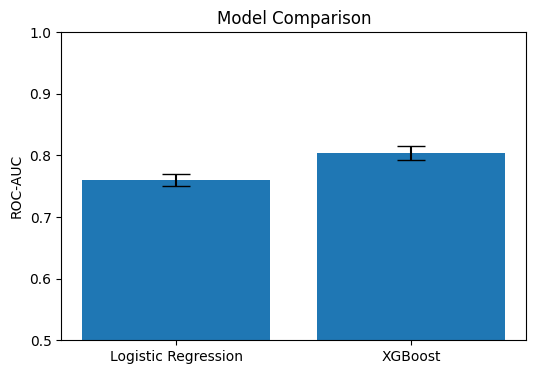

In [21]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'XGBoost']
means = [scores_lr.mean(), scores_xgb.mean()]
stds = [scores_lr.std(), scores_xgb.std()]

plt.figure(figsize=(6,4))
plt.bar(models, means, yerr=stds, capsize=10)
plt.ylabel('ROC-AUC')
plt.title('Model Comparison')
plt.ylim([0.5, 1.0])

plt.savefig("docs/img/model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()


In [21]:
import pandas as pd

leaderboard = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost"],
    "ROC-AUC (CV)": [scores_lr.mean(), scores_xgb.mean()],
    "Std": [scores_lr.std(), scores_xgb.std()]
}).sort_values("ROC-AUC (CV)", ascending=False)

leaderboard


,Model,ROC-AUC (CV),Std
1,XGBoost,0.804458,0.011354
0,Logistic Regression,0.760171,0.009277


In [22]:
leaderboard.style.highlight_max(subset=["ROC-AUC (CV)"], color="khaki")


,Model,ROC-AUC (CV),Std
1,XGBoost,0.804458,0.011354
0,Logistic Regression,0.760171,0.009277


Wyniki walidacji krzyżowej wskazują, że:

- regresja logistyczna osiąga średni ROC-AUC ≈ 0.76,
- XGBoost osiąga średni ROC-AUC ≈ 0.80.

Model XGBoost wykazuje wyraźnie lepszą zdolność do separacji klientów
wysokiego i niskiego ryzyka, przy zachowaniu stabilnych wyników
(niewielkie odchylenie standardowe między foldami).

Regresja logistyczna pełni rolę wartościowego punktu odniesienia –
pokazuje, jaką jakość predykcji można uzyskać przy użyciu prostego,
interpretowalnego modelu. Zastosowanie bardziej elastycznego modelu
drzewiastego pozwala jednak uzyskać istotną poprawę jakości predykcji.

W dalszej części projektu jako model referencyjny zostanie wykorzystany XGBoost.
